In [402]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import keras
import numpy as np
from keras.layers import Dropout

def split_dataset(data, dias, lim_treino):
    train, test = data[:lim_treino], data[lim_treino:]
    train = array(split(train, len(train)/dias))
    test = array(split(test, len(test)/dias))
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
    data = train#.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1 #movimento pra criacao de outputs
    return array(X), array(y)

def build_model(train, n_input, dias):
    train_x, train_y = to_supervised(train, n_input, dias)
    
    verbose, epochs, batch_size = 1, 100, 8
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(16, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(LSTM(8, activation='relu',return_sequences=False))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(8, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.8))
    model.add(TimeDistributed(Dense(1)))
    otimizador = keras.optimizers.RMSprop(lr=0.003, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mae', optimizer=otimizador)
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False,
              validation_split = 0.01)
    model.save('resultado.h5')
    return model

# make a forecast
def forecast(model, history, n_input):
    data = array(history)
    #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) #
    input_x = data[-n_input:, 0] #ultimas informacoes pra entrada
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

In [403]:
# evaluate a single model
def predizer(train, test, n_input, dias, model):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i])
    return array(predictions)

#### Analise de previsao de 5 dias

In [329]:
dias = 5
n_input = 20
amostras = 4800
lim_treino = amostras - dias

In [330]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

In [331]:
df = df.iloc[:amostras]

In [332]:
dataset = df['denoised']

In [333]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [334]:
model = build_model(train, n_input, dias)

Train on 185 samples, validate on 2 samples
Epoch 1/100
185/185 [==============================] - 10s 54ms/step - loss: 246.3487 - val_loss: 1035.4062
Epoch 2/100
185/185 [==============================] - 1s 6ms/step - loss: 188.6636 - val_loss: 2937.1338
Epoch 3/100
185/185 [==============================] - 1s 6ms/step - loss: 186.4466 - val_loss: 1001.9972
Epoch 4/100
185/185 [==============================] - 1s 6ms/step - loss: 201.0464 - val_loss: 1243.3147
Epoch 5/100
185/185 [==============================] - 1s 6ms/step - loss: 176.6653 - val_loss: 732.6782
Epoch 6/100
185/185 [==============================] - 1s 6ms/step - loss: 155.1880 - val_loss: 560.6079
Epoch 7/100
185/185 [==============================] - 1s 6ms/step - loss: 159.7288 - val_loss: 1293.5896
Epoch 8/100
185/185 [==============================] - 1s 5ms/step - loss: 126.2584 - val_loss: 552.4625
Epoch 9/100
185/185 [==============================] - 1s 6ms/step - loss: 130.2434 - val_loss: 750.9902
Epoc

Epoch 78/100
185/185 [==============================] - 1s 6ms/step - loss: 147.9313 - val_loss: 1981.0151
Epoch 79/100
185/185 [==============================] - 1s 6ms/step - loss: 97.2250 - val_loss: 542.2321
Epoch 80/100
185/185 [==============================] - 1s 6ms/step - loss: 98.5559 - val_loss: 388.4734
Epoch 81/100
185/185 [==============================] - 1s 5ms/step - loss: 94.5998 - val_loss: 327.6185
Epoch 82/100
185/185 [==============================] - 1s 6ms/step - loss: 84.5403 - val_loss: 325.8724
Epoch 83/100
185/185 [==============================] - 1s 6ms/step - loss: 92.9567 - val_loss: 653.4661
Epoch 84/100
185/185 [==============================] - 1s 6ms/step - loss: 102.7689 - val_loss: 130.3879
Epoch 85/100
185/185 [==============================] - 1s 6ms/step - loss: 85.3398 - val_loss: 145.9643
Epoch 86/100
185/185 [==============================] - 1s 6ms/step - loss: 94.7093 - val_loss: 308.5538
Epoch 87/100
185/185 [==============================

In [335]:
pred = predizer(train, test, n_input, dias, model)

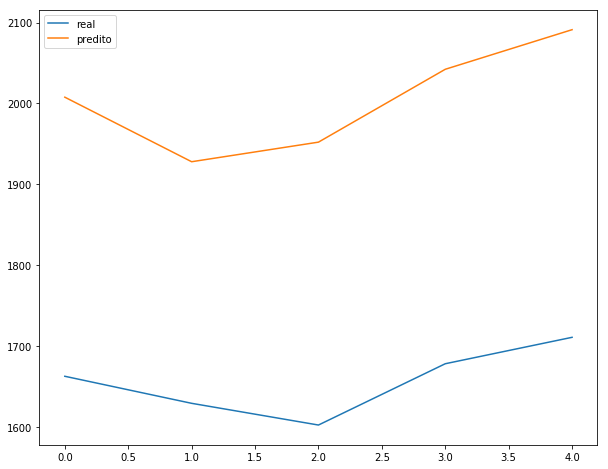

In [336]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [337]:
dias = 5
n_input = 20
amostras = 4860
lim_treino = amostras - dias

In [338]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')
df = df.iloc[:amostras]
dataset = df['denoised']

In [339]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [340]:
pred = predizer(train, test, n_input, dias, model)

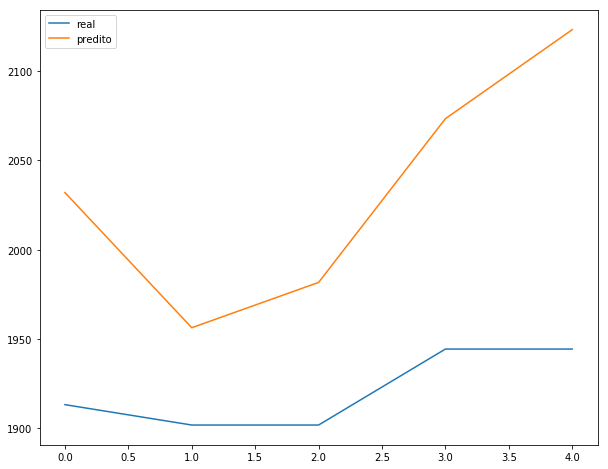

In [341]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

#### Analise de previsao de 10 dias

In [413]:
dias = 10
n_input = 30
amostras = 4600
lim_treino = amostras - dias

In [414]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

df = df.iloc[:amostras]

dataset = df['denoised']

train, test = split_dataset(dataset.values, dias, lim_treino)

In [415]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [416]:
model = build_model(train, n_input, dias)

Train on 414 samples, validate on 5 samples
Epoch 1/100
414/414 [==============================] - 18s 44ms/step - loss: 243.9323 - val_loss: 1020.7635
Epoch 2/100
414/414 [==============================] - 4s 10ms/step - loss: 176.2705 - val_loss: 930.0323
Epoch 3/100
414/414 [==============================] - 5s 12ms/step - loss: 184.6553 - val_loss: 877.6815
Epoch 4/100
414/414 [==============================] - 4s 10ms/step - loss: 180.2364 - val_loss: 876.4341
Epoch 5/100
414/414 [==============================] - 4s 10ms/step - loss: 186.1290 - val_loss: 1004.4168
Epoch 6/100
414/414 [==============================] - 4s 9ms/step - loss: 212.8511 - val_loss: 987.5394
Epoch 7/100
414/414 [==============================] - 5s 11ms/step - loss: 170.8362 - val_loss: 812.6298
Epoch 8/100
414/414 [==============================] - 4s 11ms/step - loss: 214.5064 - val_loss: 807.5550
Epoch 9/100
414/414 [==============================] - 4s 11ms/step - loss: 170.7891 - val_loss: 805.9137


Epoch 78/100
414/414 [==============================] - 3s 8ms/step - loss: 160.4400 - val_loss: 724.7597
Epoch 79/100
414/414 [==============================] - 3s 8ms/step - loss: 140.8648 - val_loss: 798.5795
Epoch 80/100
414/414 [==============================] - 3s 8ms/step - loss: 194.1749 - val_loss: 377.9890
Epoch 81/100
414/414 [==============================] - 3s 8ms/step - loss: 146.4789 - val_loss: 742.2877
Epoch 82/100
414/414 [==============================] - 3s 8ms/step - loss: 131.1120 - val_loss: 711.1727
Epoch 83/100
414/414 [==============================] - 4s 9ms/step - loss: 142.8982 - val_loss: 509.4656
Epoch 84/100
414/414 [==============================] - 4s 8ms/step - loss: 148.9748 - val_loss: 279.8982
Epoch 85/100
414/414 [==============================] - 4s 9ms/step - loss: 146.2632 - val_loss: 755.4570
Epoch 86/100
414/414 [==============================] - 4s 8ms/step - loss: 131.2086 - val_loss: 617.3800
Epoch 87/100
414/414 [========================

In [417]:
pred = predizer(train, test, n_input, dias, model)

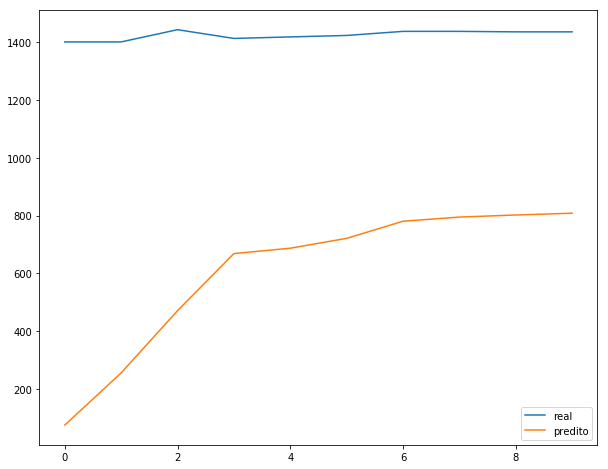

In [418]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [422]:
dias = 10
n_input = 30
amostras = 4800
lim_treino = amostras - dias

In [423]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

df = df.iloc[:amostras]

dataset = df['denoised']

train, test = split_dataset(dataset.values, dias, lim_treino)

In [424]:
pred = predizer(train, test, n_input, dias, model)

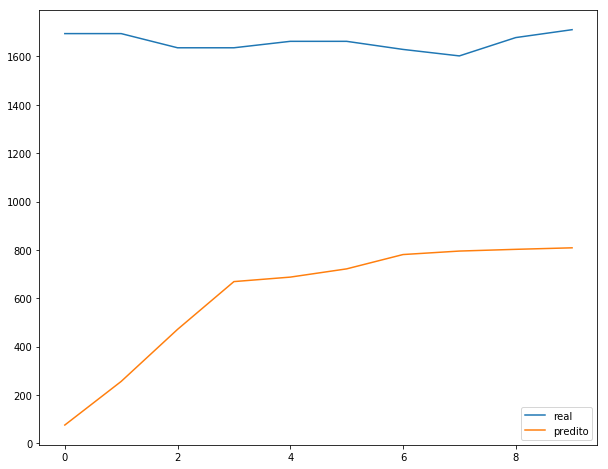

In [425]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

#### Analise de previsao de 20 dias

In [437]:
dias = 20
n_input = 60
amostras = 4600
lim_treino = amostras - dias

In [438]:
df = read_csv('/Users/Anderson/Documents/aprendizado/final/scc5943projeto/preprocessing/denoised-series.csv')

df = df.iloc[:amostras]

dataset = df['denoised']

train, test = split_dataset(dataset.values, dias, lim_treino)

In [439]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [440]:
train, test = split_dataset(dataset.values, dias, lim_treino)

In [441]:
model = build_model(train, n_input, dias)

Train on 147 samples, validate on 2 samples
Epoch 1/100
147/147 [==============================] - 21s 145ms/step - loss: 190.8412 - val_loss: 618.4348
Epoch 2/100
147/147 [==============================] - 3s 19ms/step - loss: 170312.9073 - val_loss: 788.7082
Epoch 3/100
147/147 [==============================] - 3s 21ms/step - loss: 182.3887 - val_loss: 590.7730
Epoch 4/100
147/147 [==============================] - 3s 19ms/step - loss: 249.0184 - val_loss: 537.4470
Epoch 5/100
147/147 [==============================] - 3s 22ms/step - loss: 281.9408 - val_loss: 777.0306
Epoch 6/100
147/147 [==============================] - 3s 23ms/step - loss: 180.1775 - val_loss: 519.1295
Epoch 7/100
147/147 [==============================] - 4s 28ms/step - loss: 180.2702 - val_loss: 614.8510
Epoch 8/100
147/147 [==============================] - 4s 28ms/step - loss: 191.0175 - val_loss: 601.3085
Epoch 9/100
147/147 [==============================] - 3s 21ms/step - loss: 179.7490 - val_loss: 557.23

147/147 [==============================] - 3s 20ms/step - loss: 186.6258 - val_loss: 582.1234
Epoch 78/100
147/147 [==============================] - 3s 18ms/step - loss: 183.1473 - val_loss: 545.8018
Epoch 79/100
147/147 [==============================] - 3s 19ms/step - loss: 180.1681 - val_loss: 262.3935
Epoch 80/100
147/147 [==============================] - 3s 19ms/step - loss: 201.9615 - val_loss: 421.7092
Epoch 81/100
147/147 [==============================] - 3s 19ms/step - loss: 187.3061 - val_loss: 561.8220
Epoch 82/100
147/147 [==============================] - 3s 19ms/step - loss: 169.4226 - val_loss: 620.3518
Epoch 83/100
147/147 [==============================] - 3s 18ms/step - loss: 157.1395 - val_loss: 553.9309
Epoch 84/100
147/147 [==============================] - 3s 20ms/step - loss: 172.8660 - val_loss: 352.3846
Epoch 85/100
147/147 [==============================] - 3s 17ms/step - loss: 197.3232 - val_loss: 465.9031
Epoch 86/100
147/147 [============================

In [442]:
pred = predizer(train, test, n_input, dias, model)

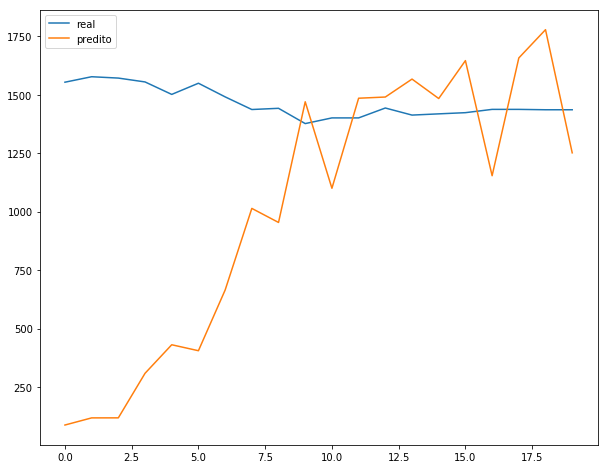

In [443]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [444]:
pred = predizer(train, train, n_input, dias, model)

In [449]:
train.shape

(229, 20)

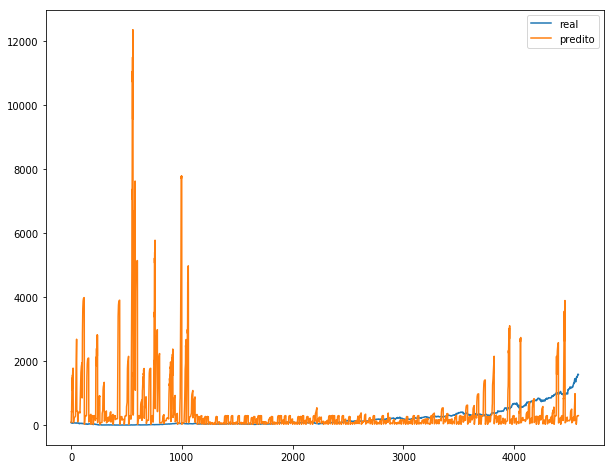

In [450]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(train.flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()